In [11]:
import __init__

import glob
import os
import warnings
import numpy as np;
 
import skimage.io as io
from skimage import morphology
from skimage import feature
from skimage import measure
from skimage import segmentation
from skimage.transform import resize
from skimage import filters
from skimage import img_as_ubyte

import matplotlib as plt

import cfg
import imtools
import diagnostics
import segmentations
import cell_morphology
import annotations

%matplotlib inline 

Setting parameters

In [2]:
param=cfg.param() 
output_dir=param.getOutDir('output')
diag_dir=param.getOutDir('diag')
vis_diag=False

Selecting an image file to process

In [3]:
imDirs=os.listdir(param.getImageDirs())
print(imDirs)
image_dir=param.getImageDirs(dir_name=imDirs[-1])
included_extenstions = ['*.jpg', '*.bmp', '*.png', '*.gif']
image_list_indir = []
for ext in included_extenstions:
   image_list_indir.extend(glob.glob(os.path.join(image_dir, ext)))

for i, image_file in enumerate(image_list_indir):
    print(str(i)+' : '+image_file)

['Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Problem']
0 : .\data\Test\WBC Types\Problem\99_EO.jpg
1 : .\data\Test\WBC Types\Problem\100_K32.bmp
2 : .\data\Test\WBC Types\Problem\103_K32.bmp
3 : .\data\Test\WBC Types\Problem\105_K32.bmp
4 : .\data\Test\WBC Types\Problem\11_17_gepi_5_8_13.bmp
5 : .\data\Test\WBC Types\Problem\11_K32.bmp
6 : .\data\Test\WBC Types\Problem\13_LY.bmp
7 : .\data\Test\WBC Types\Problem\14_17_gepi_5_8_13.bmp
8 : .\data\Test\WBC Types\Problem\159_K32.bmp
9 : .\data\Test\WBC Types\Problem\17_LY.bmp
10 : .\data\Test\WBC Types\Problem\1_10223_251_2350.bmp
11 : .\data\Test\WBC Types\Problem\208_K32.bmp
12 : .\data\Test\WBC Types\Problem\36_NE.bmp
13 : .\data\Test\WBC Types\Problem\45_MO.bmp
14 : .\data\Test\WBC Types\Problem\47_NE.bmp
15 : .\data\Test\WBC Types\Problem\49_NE.bmp
16 : .\data\Test\WBC Types\Problem\52_NE.bmp
17 : .\data\Test\WBC Types\Problem\80_LY.bmp
18 : .\data\Test\WBC Types\Problem\8_NE.bmp
19 : .\data\Test\WBC Types\Probl

In [4]:
image_file=image_list_indir[0]
print(image_file)

.\data\Test\WBC Types\Problem\99_EO.jpg


Read image

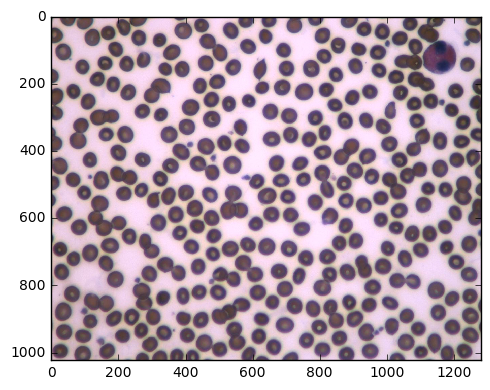

In [12]:
im = io.imread(image_file) # read uint8 image
io.imshow(im)

Do diagnostics:
- color space conversion (HSV is used)
- initializing background detection with n=4 KMEANS clustering on saturation (S) and value (V) channels
- estimating cell size using blob detection
- estimating overexposition
- estimating inhomogen illumination from background piyels
- illumination correction with inpainting technology
- estimating contrast, high saturation areas

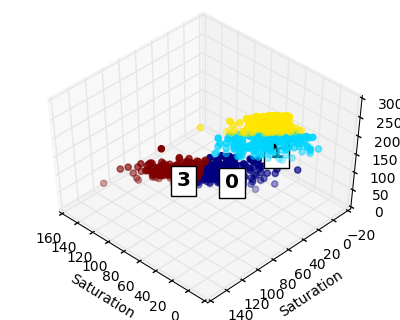

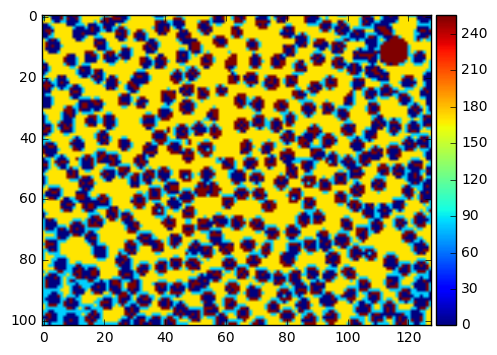

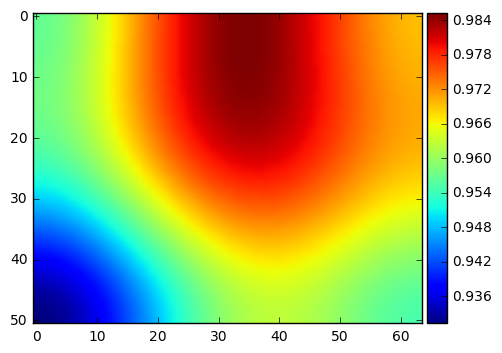

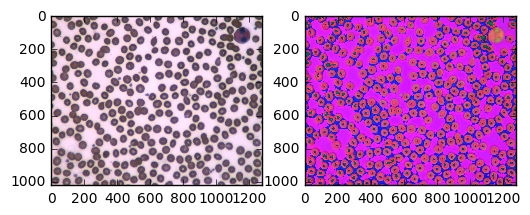

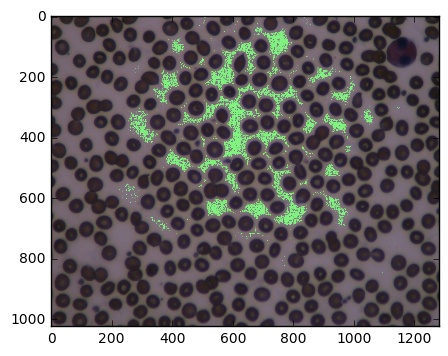

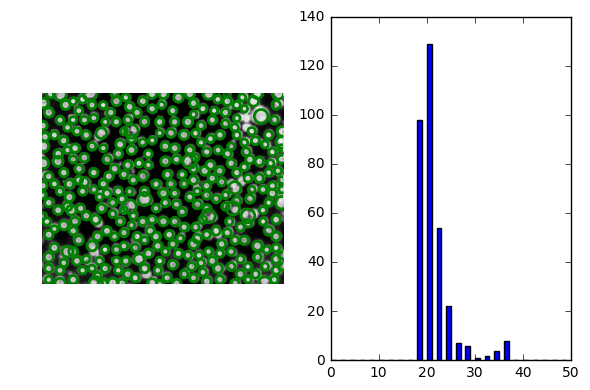

Error list:
ch_maxvar :0
saturation_q90 :87


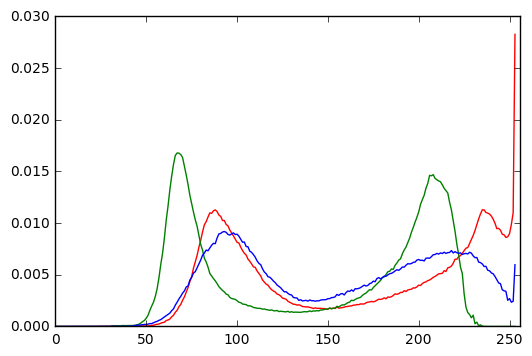

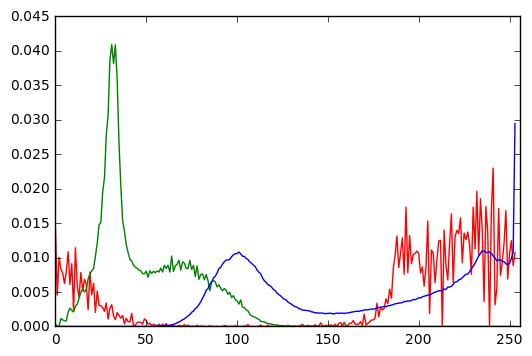

In [6]:
diag=diagnostics.diagnostics(im,image_file,vis_diag=True)


Resizing images for processing

In [13]:
hsv_resize, scale=imtools.imRescaleMaxDim(diag.hsv_corrected,diag.param.middle_size,interpolation = 0)
im_resize, scale=imtools.imRescaleMaxDim(diag.im_corrected,diag.param.middle_size,interpolation = 0)

Create adaptive foreground mask using previously set init centers - n=4 KMEANS is used

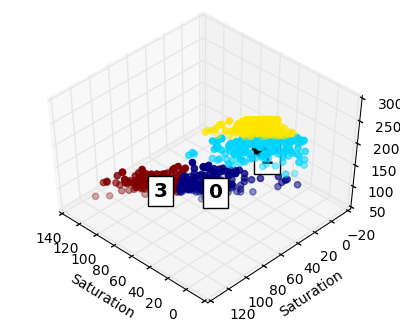

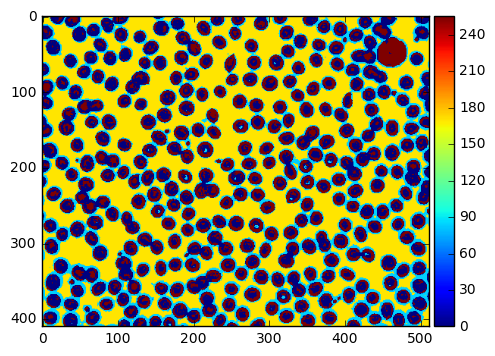

In [14]:
clust_centers_0, label_0 = segmentations.segment_hsv(hsv_resize, init_centers=diag.cent_init,\
                                                    chs=(1,1,2),\
                                                    n_clusters=4,\
                                                    vis_diag=True)   
label_fg_bg=cell_morphology.rbc_labels(im,clust_centers_0,label_0)

Creating wbc nucleus mask with n=4 KMEANS clustering on Hue (H) channel

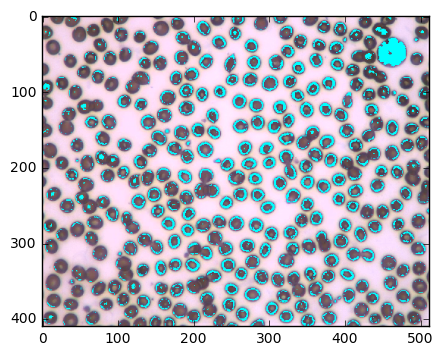

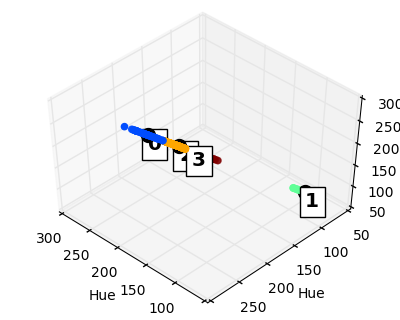

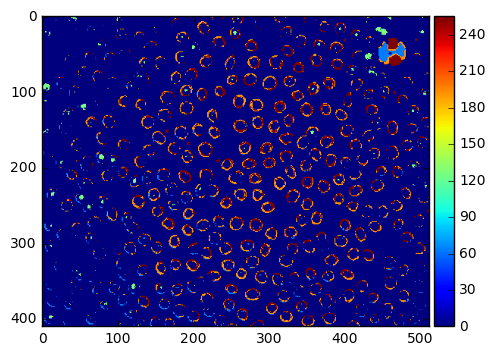

In [16]:
mask_sat=np.logical_and(np.logical_and(hsv_resize[:,:,0]>0,hsv_resize[:,:,0]<300),\
                                           hsv_resize[:,:,1]>diag.sat_q90)
    
wbc_nuc=imtools.overlayImage(im_resize,mask_sat,(0,1,1),1,vis_diag=True,fig='nuc_mask')

clust_centers_1, label_1 = segmentations.segment_hsv(hsv_resize, mask=mask_sat,\
                                                cut_channel=1, chs=(0,0,0),\
                                                n_clusters=4,\
                                                vis_diag=True) 